In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error

# Load dataset
df = pd.read_csv("data\Retail_Dataset2.csv")

In [164]:
df.head()

,Product_id,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price
0,786725,Product_0033,Whse_S,Category_005,01/03/2016,16000,1,0,0,0,91
1,786743,Product_1825,Whse_S,Category_006,01/03/2016,50000,1,0,0,0,85
2,786967,Product_0551,Whse_S,Category_030,01/03/2016,3000,1,0,0,0,85
3,786856,Product_0556,Whse_S,Category_030,01/03/2016,1000,1,0,0,0,93
4,899538,Product_1844,Whse_A,Category_018,01/03/2016,7,1,0,0,0,95


In [94]:
df.shape

(169198, 28)

In [76]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [77]:
import numpy as np 
df['Order_Demand'] = df['Order_Demand'].clip(lower=0)  # Just in case
df['Order_Demand'] = np.log1p(df['Order_Demand'])  # log(1 + x)

In [78]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)


In [79]:
df['lag_1'] = df['Order_Demand'].shift(1)
df['rolling_mean_3'] = df['Order_Demand'].shift(1).rolling(3).mean()

In [80]:
df['lag_7'] = df['Order_Demand'].shift(7)
df['rolling_mean_7'] = df['Order_Demand'].shift(1).rolling(window=7).mean()
df['rolling_std_7'] = df['Order_Demand'].shift(1).rolling(window=7).std()


In [81]:
df['sma_7'] = df['Order_Demand'].rolling(window=7).mean()
df['sma_14'] = df['Order_Demand'].rolling(window=14).mean()


In [82]:
df['ema_7'] = df['Order_Demand'].ewm(span=7, adjust=False).mean()
df['ema_14'] = df['Order_Demand'].ewm(span=14, adjust=False).mean()


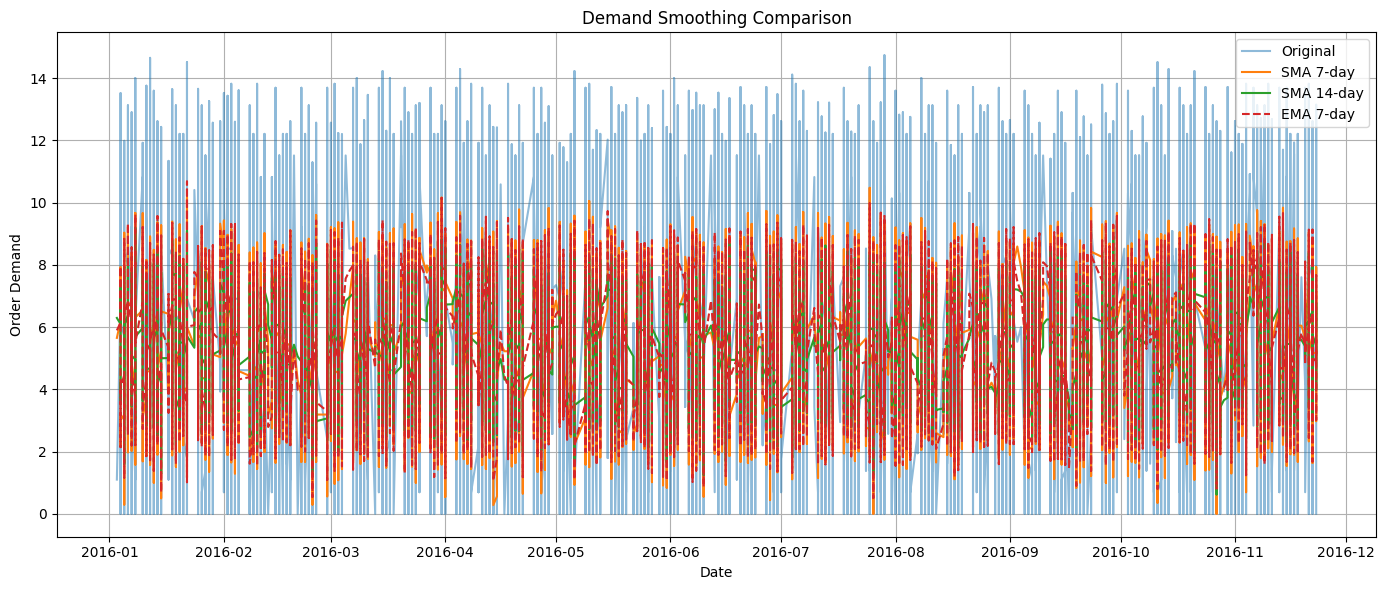

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Order_Demand'], label='Original', alpha=0.5)
plt.plot(df['Date'], df['sma_7'], label='SMA 7-day')
plt.plot(df['Date'], df['sma_14'], label='SMA 14-day')
plt.plot(df['Date'], df['ema_7'], label='EMA 7-day', linestyle='--')
plt.legend()
plt.title('Demand Smoothing Comparison')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:
df = df.dropna(subset=['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7','sma_14'])

In [90]:
print(df[['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7','sma_14']].isnull().sum())

lag_1             0
rolling_mean_3    0
lag_7             0
rolling_mean_7    0
rolling_std_7     0
sma_14            0
dtype: int64


In [96]:
ts = df['Order_Demand']  # replace with your actual column name

# Train-test split (80% train, 20% test)
split_index = int(len(ts) * 0.8)
train = ts.iloc[:split_index]
test = ts.iloc[split_index:]

In [97]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=41.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=755540.962, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=719912.880, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=755538.962, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=705826.322, Time=3.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=698267.833, Time=3.69 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=693791.868, Time=5.54 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=690500.900, Time=5.50 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=66.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=90.51 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=690498.900, Time=3.96 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=693789.868, Time=3.30 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=31.76 sec
 ARIMA(4,1,1)(0,0,0)[0]            

In [98]:
model = ARIMA(train, order=stepwise_model.order) # (p,d,q) — adjust as needed
model_fit = model.fit()

# Forecast for the test set
forecast = model_fit.forecast(steps=len(test))

In [99]:
r2 = r2_score(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)

print("R² Score:", r2)
print("RMSE:", rmse)

R² Score: -0.05259591667143315
RMSE: 2.986942864949781


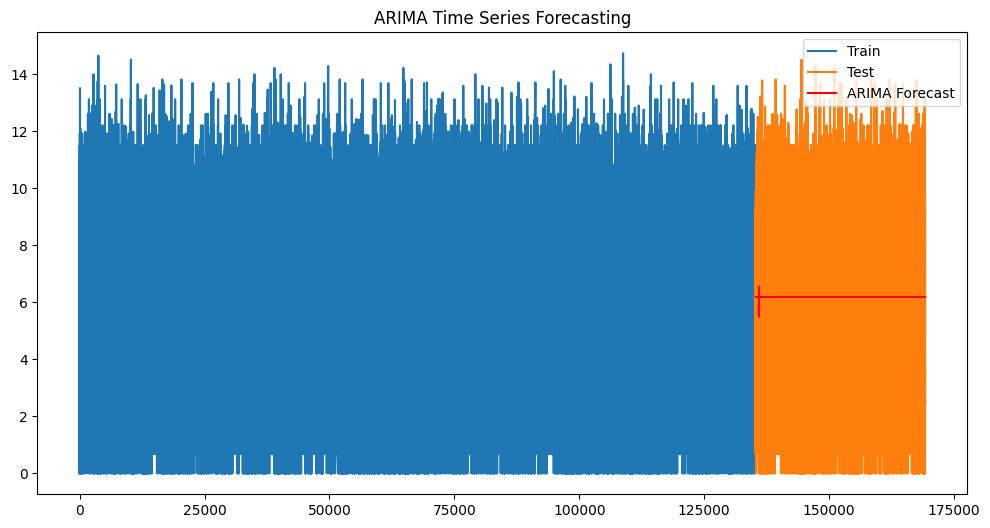

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.title("ARIMA Time Series Forecasting")
plt.legend()
plt.show()
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['prev_day_demand'] = df['Order_Demand'].shift(1)
df['rolling_avg_7'] = df['Order_Demand'].rolling(window=7).mean()


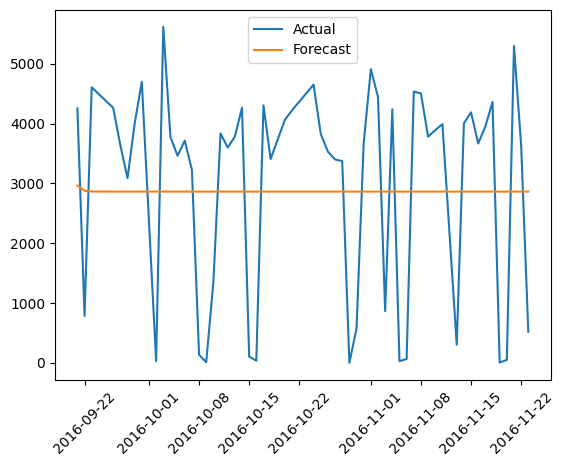

In [101]:
df['Date'] = pd.to_datetime(df['Date'])  # if not already
df['Order_Demand'] = df['Order_Demand'].astype(int)  # clean quantity column

# Group total demand by date
daily_demand = df.groupby('Date')['Order_Demand'].sum().reset_index()

# Now apply ARIMA to total demand
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand[:train_size], daily_demand[train_size:]

model = ARIMA(train['Order_Demand'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot actual vs forecast
import matplotlib.pyplot as plt
plt.plot(test['Date'], test['Order_Demand'], label='Actual')
plt.plot(test['Date'], forecast, label='Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [102]:
from pmdarima import auto_arima

# assume `daily_demand` is your time series DataFrame
stepwise_model = auto_arima(train['Order_Demand'], 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

stepwise_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4399.551, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4177.184, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4285.608, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4160.100, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4145.181, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4139.067, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4135.412, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4054.054, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4060.574, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4052.488, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4061.825, Time=0.09 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=4064.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  231
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -1995.959
Date:                Thu, 17 Jul 2025   AIC                           4015.919
Time:                        14:02:28   BIC                           4057.228
Sample:                             0   HQIC                          4032.580
                                - 231                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4394.5873   3770.716      1.165      0.244   -2995.880    1.18e+04
ar.L1          0.4285      0.478      0.896      0.370      -0.508       1.366
ar.L2         -0.8991      0.078    -11.580      0.000      -1.051      -0.747
ar.L3          0.4257      0.450      0.946      0.344      -0.457       1.308
ar.L4         -0.8533      0.064    -13.326      0.000      -0.979      -0.728
ar.L5          0.3799      0.419      0.908      0.364      -0.440       1.200
ma.L1         -0.2861      0.455     -0.629      0.529      -1.177       0.605
ma.L2          0.7589      0.115      6.600      0.000       0.534       0.984
ma.L3         -0.3111      0.406     -0.766      0.444      -1.107       0.485
ma.L4          0.5783      0.110      5.237      0.000       0.362       0.795
ma.L5         -0.4294      0.300     -1.433      0.152      -1.017       0.158
sigma2      1.941e+06   2.39e+05      8.122      0.000    1.47e+06    2.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.51   Prob(JB):                         0.35
Heteroskedasticity (H):               1.21   Skew:                            -0.12
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
forecast = stepwise_model.predict(n_periods=len(test))


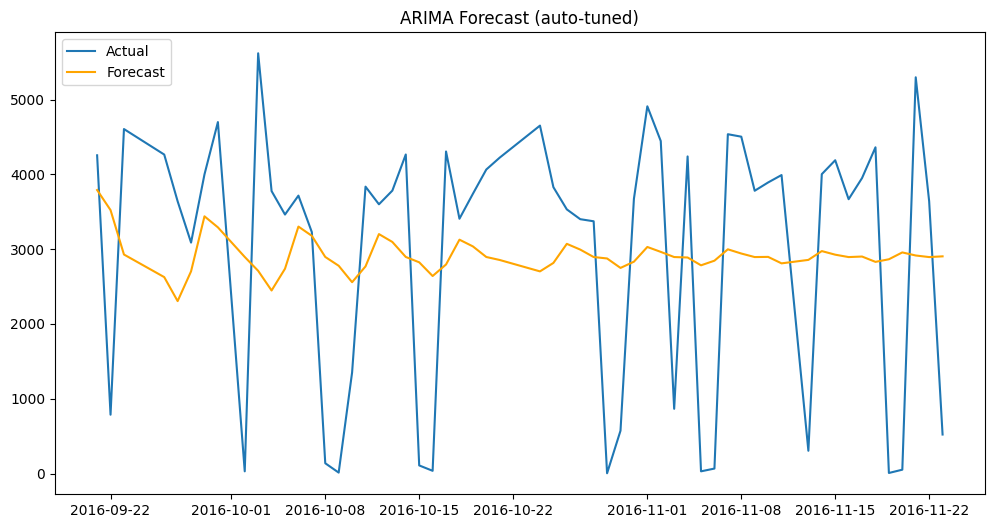

In [104]:
plt.figure(figsize=(12,6))
plt.plot(test['Date'], test['Order_Demand'], label='Actual')
plt.plot(test['Date'], forecast, label='Forecast', color='orange')
plt.title('ARIMA Forecast (auto-tuned)')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4055.719, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4070.426, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4070.430, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4069.100, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4399.551, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4074.272, Time=0.12 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4074.363, Time=0.28 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=4053.824, Time=0.50 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=4075.333, Time=0.50 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=4055.012, Time=0.83 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=4054.083, Time=0.46 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=4072.666, Time=0.35 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=4074.491, Time=0.31 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=4056.503, Time=0.64 sec
 ARIMA(2,0,3)(2,0,1)[7] intercept

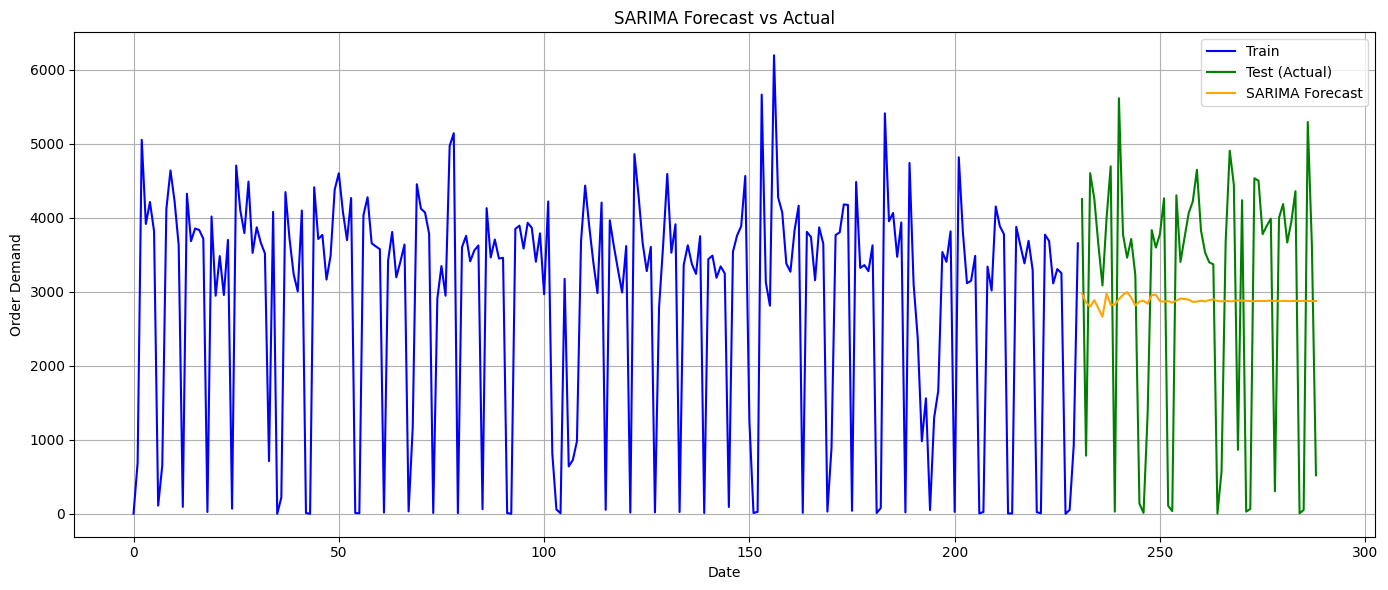

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Train SARIMA
sarima_model = auto_arima(train['Order_Demand'],
                          seasonal=True,
                          m=7,  # Weekly seasonality
                          trace=True,
                          stepwise=True,
                          suppress_warnings=True)

# Forecast on test set
sarima_forecast = sarima_model.predict(n_periods=len(test))

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Order_Demand'], label='Train', color='blue')
plt.plot(test.index, test['Order_Demand'], label='Test (Actual)', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [106]:
pip install prophet

In [165]:
import pandas as pd

# Convert date column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Group by date and sum Order_Demand
df_daily = df.groupby('Date').agg({'Order_Demand': 'sum'}).reset_index()

# Rename for Prophet
df_daily = df_daily.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})


In [166]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(df_daily)


10:13:24 - cmdstanpy - INFO - Chain [1] start processing
10:13:25 - cmdstanpy - INFO - Chain [1] done processing


In [167]:
future = model.make_future_dataframe(periods=30)  # predict 30 days into future
forecast = model.predict(future)


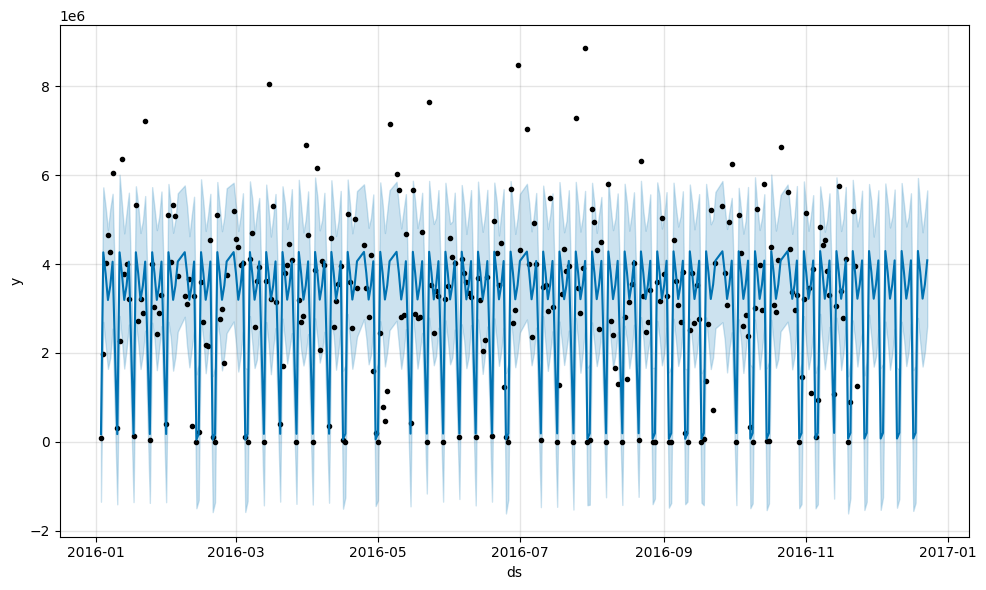

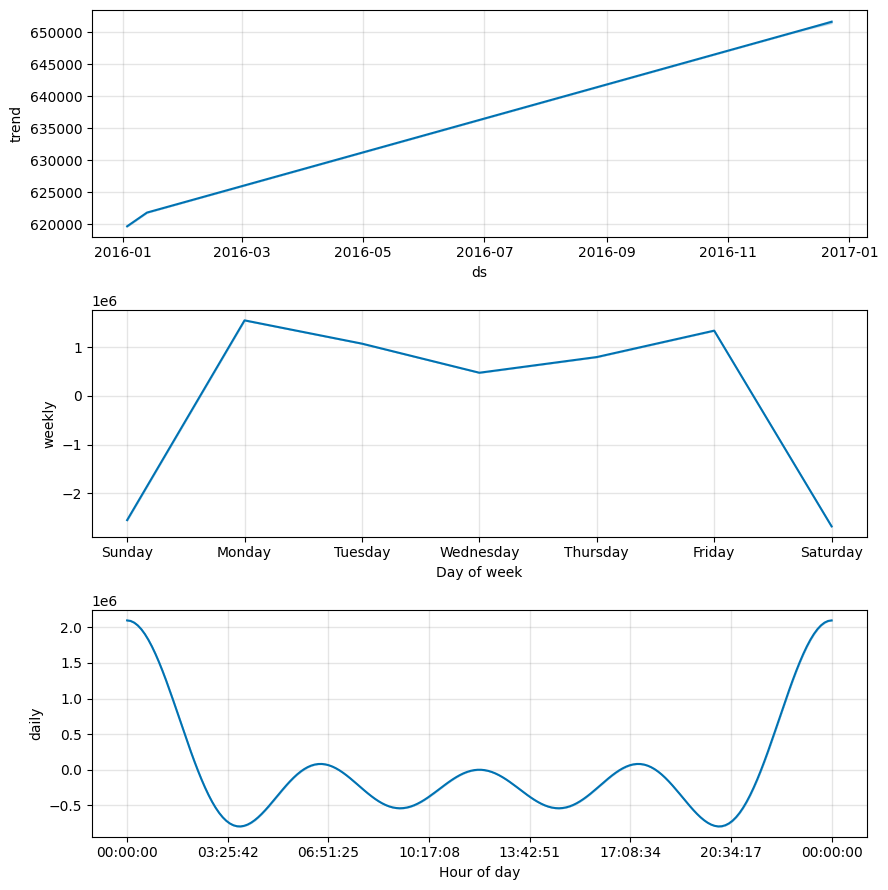

In [168]:
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)


In [169]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Only use historical part for evaluation
merged = pd.merge(df_daily, forecast[['ds', 'yhat']], on='ds')

rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
r2 = r2_score(merged['y'], merged['yhat'])

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 1211434.4330116939
R² Score: 0.5961743413557592


In [170]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='180 days', period='15 days', horizon='30 days', parallel="processes")
df_p = performance_metrics(df_cv)

print(df_p.columns)

Index(['horizon', 'mse', 'rmse', 'mae', 'mdape', 'smape', 'coverage'], dtype='object')


In [171]:
from sklearn.metrics import r2_score

# yhat is the prediction, y is the actual
r2 = r2_score(df_cv['y'], df_cv['yhat'])
print("Manual R² Score:", r2)


Manual R² Score: 0.5961525329361859


In [172]:
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.diagnostics import cross_validation

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_r2 = -1
best_params = None

for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        for sm in param_grid['seasonality_mode']:
            model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                seasonality_mode=sm
            )
            model.fit(df_daily)

            df_cv = cross_validation(model, initial='180 days', period='15 days', horizon='30 days', parallel="processes")
            r2 = r2_score(df_cv['y'], df_cv['yhat'])

            print(f"Params: cps={cps}, sps={sps}, sm={sm} → R²: {r2:.4f}")

            if r2 > best_r2:
                best_r2 = r2
                best_params = {'cps': cps, 'sps': sps, 'sm': sm}


10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=5.0, sm=additive → R²: 0.5844


10:13:56 - cmdstanpy - INFO - Chain [1] start processing
10:13:56 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=5.0, sm=multiplicative → R²: 0.5539


10:14:00 - cmdstanpy - INFO - Chain [1] start processing
10:14:00 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=10.0, sm=additive → R²: 0.5878


10:14:05 - cmdstanpy - INFO - Chain [1] start processing
10:14:05 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=10.0, sm=multiplicative → R²: 0.5511


10:14:10 - cmdstanpy - INFO - Chain [1] start processing
10:14:10 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=20.0, sm=additive → R²: 0.5748


10:14:16 - cmdstanpy - INFO - Chain [1] start processing
10:14:16 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=20.0, sm=multiplicative → R²: 0.5383


10:14:21 - cmdstanpy - INFO - Chain [1] start processing
10:14:21 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=5.0, sm=additive → R²: 0.5986


10:14:26 - cmdstanpy - INFO - Chain [1] start processing
10:14:27 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=5.0, sm=multiplicative → R²: 0.5917


10:14:31 - cmdstanpy - INFO - Chain [1] start processing
10:14:31 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=10.0, sm=additive → R²: 0.5966


10:14:37 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=10.0, sm=multiplicative → R²: 0.5862


10:14:43 - cmdstanpy - INFO - Chain [1] start processing
10:14:43 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=20.0, sm=additive → R²: 0.5989


10:14:49 - cmdstanpy - INFO - Chain [1] start processing
10:14:49 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=20.0, sm=multiplicative → R²: 0.5900


10:14:54 - cmdstanpy - INFO - Chain [1] start processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=5.0, sm=additive → R²: 0.5956


10:15:00 - cmdstanpy - INFO - Chain [1] start processing
10:15:00 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=5.0, sm=multiplicative → R²: 0.5777


10:15:07 - cmdstanpy - INFO - Chain [1] start processing
10:15:07 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=10.0, sm=additive → R²: 0.5940


10:15:14 - cmdstanpy - INFO - Chain [1] start processing
10:15:14 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=10.0, sm=multiplicative → R²: 0.5803


10:15:21 - cmdstanpy - INFO - Chain [1] start processing
10:15:21 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=20.0, sm=additive → R²: 0.5970


10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=20.0, sm=multiplicative → R²: 0.5789


In [173]:
model = Prophet()

# Add regressors
model.add_regressor('Open')
model.add_regressor('Promo')
model.add_regressor('StateHoliday')
model.add_regressor('SchoolHoliday')
model.add_regressor('Petrol_price')


In [174]:
df_daily.columns

Index(['ds', 'y'], dtype='object')

In [175]:
from prophet import Prophet

model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(df_daily)


10:15:33 - cmdstanpy - INFO - Chain [1] start processing
10:15:33 - cmdstanpy - INFO - Chain [1] done processing


In [176]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score

# 1. Perform cross-validation
df_cv = cross_validation(
    model,
    initial='210 days',
    period='30 days',
    horizon='60 days'
)

# 2. Get metrics
df_perf = performance_metrics(df_cv)

# 3. Manually calculate R² using true vs predicted
r2 = r2_score(df_cv['y'], df_cv['yhat'])
print(f"R² Score: {r2:.4f}")


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]10:15:34 - cmdstanpy - INFO - Chain [1] start processing
10:15:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.72it/s]10:15:34 - cmdstanpy - INFO - Chain [1] start processing
10:15:34 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


R² Score: -0.1093


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169211 entries, 0 to 169210
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_id        169211 non-null  int64         
 1   Product_Code      169211 non-null  object        
 2   Warehouse         169211 non-null  object        
 3   Product_Category  169211 non-null  object        
 4   Date              169211 non-null  datetime64[ns]
 5   Order_Demand      169211 non-null  int64         
 6   Open              169211 non-null  int64         
 7   Promo             169211 non-null  int64         
 8   StateHoliday      169211 non-null  object        
 9   SchoolHoliday     169211 non-null  int64         
 10  Petrol_price      169211 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 14.2+ MB


In [178]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Extract time features
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df.drop(columns='Date', inplace=True)

# Prepare data
X = df.drop(columns=['Order_Demand'])  # drop datetime
y = df['Order_Demand']

# One-hot encode
X_full = pd.get_dummies(X, columns=['Warehouse', 'Product_Category', 'StateHoliday','Product_Code'], drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Train
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))

# Feature importance



R² Score: 0.4157697943039256


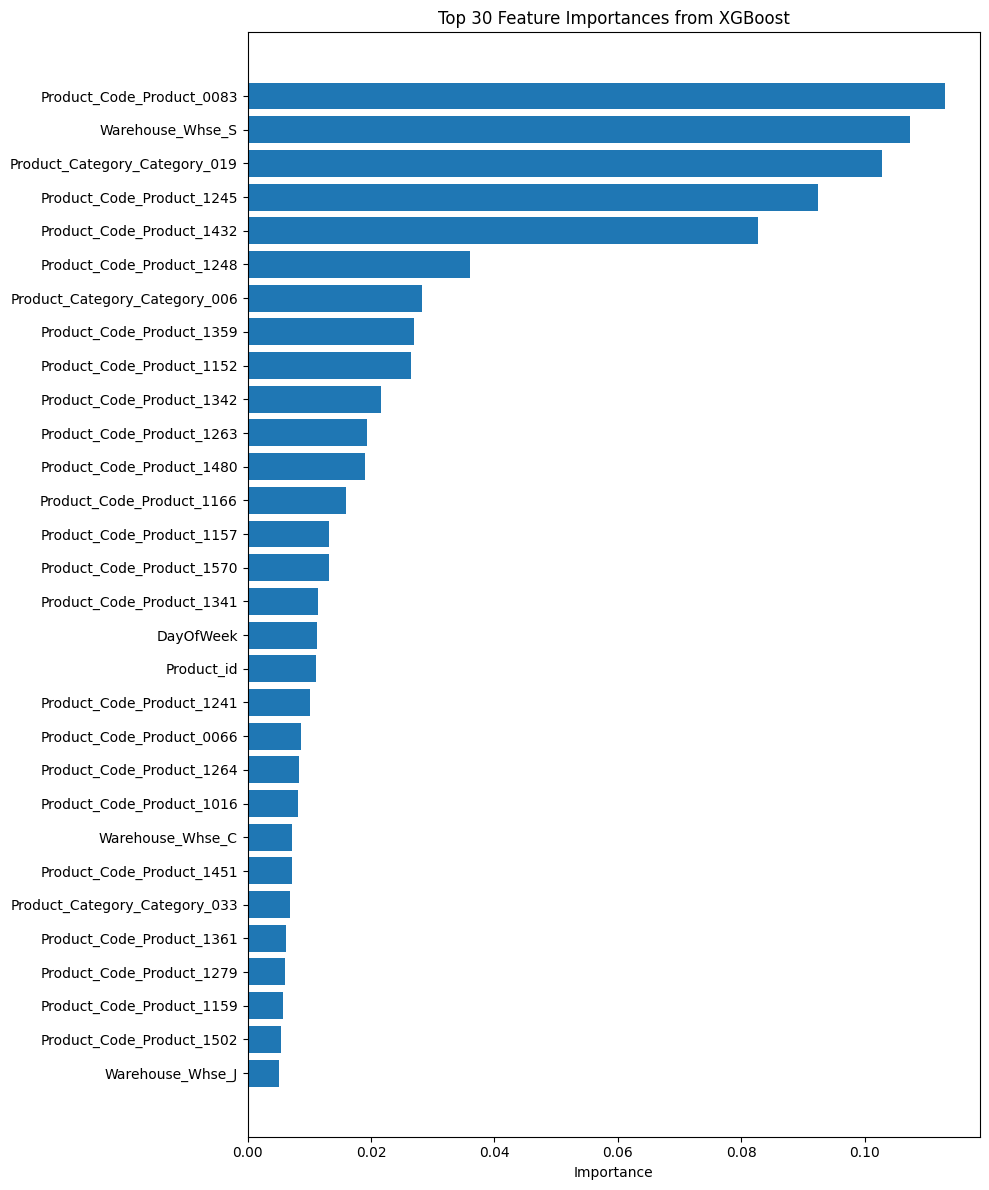

In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort
importances = model.feature_importances_
feature_names = X_full.columns
indices = np.argsort(importances)[::-1]  # descending

# Choose top 30 features
top_n = 30
top_features = feature_names[indices][:top_n]
top_importances = importances[indices][:top_n]

# Plot
plt.figure(figsize=(10, 12))
plt.barh(top_features[::-1], top_importances[::-1])  # reverse for top-to-bottom
plt.title("Top 30 Feature Importances from XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [181]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

# Initialize model
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=100
)

# Fit model
cat_model.fit(X_train, y_train)

# Predict and evaluate
cat_preds = cat_model.predict(X_test)
print("CatBoost R² Score:", r2_score(y_test, cat_preds))


0:	learn: 30965.3169239	total: 25.8ms	remaining: 25.7s
100:	learn: 22172.7822709	total: 2.25s	remaining: 20.1s
200:	learn: 20272.8685183	total: 4.27s	remaining: 17s
300:	learn: 19310.1965737	total: 6.37s	remaining: 14.8s
400:	learn: 18524.5517264	total: 8.72s	remaining: 13s
500:	learn: 17874.3968148	total: 11.8s	remaining: 11.7s
600:	learn: 17284.2494153	total: 14.7s	remaining: 9.75s
700:	learn: 16846.5900732	total: 17.5s	remaining: 7.47s
800:	learn: 16440.6417771	total: 20.1s	remaining: 5s
900:	learn: 16049.0980593	total: 22.8s	remaining: 2.51s
999:	learn: 15761.5840014	total: 25.4s	remaining: 0us
CatBoost R² Score: 0.4448756149388581


In [182]:
from lightgbm import LGBMRegressor

# Initialize model
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6
)

# Fit model
lgb_model.fit(X_train, y_train)

# Predict and evaluate
lgb_preds = lgb_model.predict(X_test)
print("LightGBM R² Score:", r2_score(y_test, lgb_preds))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 135368, number of used features: 1371
[LightGBM] [Info] Start training from score 5236.231909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [183]:
import pandas as pd
import time
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

# Drop 'Date'
X = df.drop(columns=['Order_Demand',])
y = df['Order_Demand']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Models to compare
models = {
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6),
    'CatBoost': CatBoostRegressor(verbose=0, n_estimators=200, learning_rate=0.1, depth=6),
    'LightGBM': LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
}

# To store results
results = []

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start_time
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'R2 Score': round(r2, 4),
        'Time (s)': round(duration, 2)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

# Show comparison
print("Model Comparison:")
print(results_df)

# Select the best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n✅ Best Model: {best_model_name}")

# Cross Validation for robustness
cv_scores = cross_val_score(best_model, X_encoded, y, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 135368, number of used features: 1371
[LightGBM] [Info] Start training from score 5236.231909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [184]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

# Use the same config
final_model = CatBoostRegressor(verbose=0, n_estimators=200, learning_rate=0.1, depth=6)

# Perform 5-fold CV
cv_scores = cross_val_score(final_model, X_encoded, y, cv=5, scoring='r2')

# Output results
print(f"CatBoost Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

CatBoost Cross-Validation R² Scores: [0.44422738 0.55369083 0.34906064 0.44570924 0.39486648]
Mean R² Score: 0.4375
Standard Deviation: 0.0682


In [162]:
print(X_train.columns)

Index(['Product_id', 'Open', 'Promo', 'SchoolHoliday', 'Petrol_price', 'year',
       'month', 'day', 'dayofweek', 'is_weekend',
       ...
       'Product_Category_Category_026', 'Product_Category_Category_027',
       'Product_Category_Category_028', 'Product_Category_Category_029',
       'Product_Category_Category_030', 'Product_Category_Category_031',
       'Product_Category_Category_032', 'Product_Category_Category_033',
       'StateHoliday_a', 'StateHoliday_b'],
      dtype='object', length=2180)
